In [2]:
import numpy as np
import pandas as pd
import os
import string
import re
import warnings 
warnings.filterwarnings('ignore')

#plotting libraries!
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
%matplotlib inline


#PLOTLY
import plotly
import plotly.plotly as py
import plotly.offline as offline
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import cufflinks as cf
from collections import defaultdict
from plotly import tools
from plotly.graph_objs import Scatter, Figure, Layout
cf.set_config_file(offline=True)
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
eng_stopwords = set(stopwords.words("english"))
from wordcloud import WordCloud, STOPWORDS
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis.sklearn
from pylab import bone, pcolor, colorbar, plot, show, rcParams, savefig
import squarify


In [3]:
twitter_data = pd.read_csv('auspol2019.csv', parse_dates = ['created_at', 'user_created_at'])
geo_data = pd.read_csv('location_geocode.csv')

In [4]:
twitter_data.head()

created_at                   id  \
0  2019-05-20 09:13:44  1130401208756187136   
1  2019-05-20 09:13:43  1130401205367140357   
2  2019-05-20 09:13:33  1130401162782371841   
3  2019-05-20 09:13:29  1130401143551434753   
4  2019-05-20 09:13:23  1130401118666809345   

                                           full_text  retweet_count  \
0  After the climate election: shellshocked green...            0.0   
1  @narendramodi @smritiirani Coverage of indian ...            0.0   
2  @workmanalice Do you know if Facebook is relea...            0.0   
3  @vanbadham We all understand we have a compuls...            0.0   
4  Shares were mixed in Asia, with India and Aust...            0.0   

   favorite_count       user_id          user_name user_screen_name  \
0             0.0  9.248486e+07       PIPELINEPETE         jocksjig   
1             0.0  7.756474e+08    Narinder Parmar      nparmar1957   
2             0.0  5.687300e+04        Peter Wells       peterwells   
3             0.0  9.081660e+17        The Realist    therealist822   
4             0.0  5.260074e+08  Inquirer Business      InquirerBiz   

                                    user_description  \
0  Retired Tradesman and Progressive Anti Conserv...   
1  Life coach & trainer, Motivational speaker, Ma...   
2  Writes for @theage and @smh on technology and ...   
3  Calls it as I see it. Anti PC, SJW and VS. If ...   
4  The official Twitter account of the Inquirer G...   

                user_location     user_created_at  
0        Brisbane, Queensland 2009-11-25 09:19:45  
1  Wollongong, NSW, AUSTRALIA 2012-08-23 10:20:40  
2                   Melbourne 2006-12-11 07:38:06  
3                         NaN 2017-09-14 03:10:30  
4                 Philippines 2012-03-16 03:51:59

In [5]:
geo_data.head()

name        lat        long
0        Brisbane, Queensland -27.469771  153.025124
1  Wollongong, NSW, AUSTRALIA -34.427812  150.893061
2                   Melbourne -37.813628  144.963058
3                 Philippines  12.879721  121.774017
4                   Australia -25.274398  133.775136

In [6]:
twitter_data.shape, geo_data.shape

((183379, 11), (11153, 3))

In [7]:
twitter_data = twitter_data.merge(geo_data, how = 'inner', left_on= 'user_location', right_on= 'name')

In [8]:
twitter_data.head()

created_at                   id  \
0  2019-05-20 09:13:44  1130401208756187136   
1  2019-05-20 09:12:57  1130401009782673408   
2  2019-05-20 09:02:04  1130398270813949952   
3  2019-05-20 07:25:41  1130374015103537152   
4  2019-05-20 07:12:01  1130370578584461313   

                                           full_text  retweet_count  \
0  After the climate election: shellshocked green...            0.0   
1  It is disappointing that @tanya_plibersek has ...            0.0   
2  'Vote for the climate': NSW demands environmen...            0.0   
3  This is urgent! “False election claims spark p...            0.0   
4  This is a great piece, not least because it pl...            0.0   

   favorite_count       user_id       user_name user_screen_name  \
0             0.0  9.248486e+07    PIPELINEPETE         jocksjig   
1             0.0  5.100258e+07  Matthew Rimmer         DrRimmer   
2             0.0  9.248486e+07    PIPELINEPETE         jocksjig   
3             0.0  3.327641e+08         E Ferri         eneferri   
4             2.0  2.180023e+09  Shahar Hameiri    ShaharHameiri   

                                    user_description         user_location  \
0  Retired Tradesman and Progressive Anti Conserv...  Brisbane, Queensland   
1  Professor of IP & Innovation Law @QUTLaw @QUT_...  Brisbane, Queensland   
2  Retired Tradesman and Progressive Anti Conserv...  Brisbane, Queensland   
3  Writer, researcher, educator in media, adverti...  Brisbane, Queensland   
4  Associate Professor @polsisengage @UQ_news. Po...  Brisbane, Queensland   

      user_created_at                  name        lat        long  
0 2009-11-25 09:19:45  Brisbane, Queensland -27.469771  153.025124  
1 2009-06-26 10:17:54  Brisbane, Queensland -27.469771  153.025124  
2 2009-11-25 09:19:45  Brisbane, Queensland -27.469771  153.025124  
3 2011-07-10 11:20:43  Brisbane, Queensland -27.469771  153.025124  
4 2013-11-07 12:39:24  Brisbane, Queensland -27.469771  153.025124

In [9]:
twitter_data = twitter_data.drop('name', axis=1)

In [13]:
twitter_data.isnull().mean()*100

created_at          0.000000
id                  0.000000
full_text           0.000000
retweet_count       0.000000
favorite_count      0.000000
user_id             0.000000
user_name           0.000000
user_screen_name    0.000000
user_description    4.115822
user_location       0.000000
user_created_at     0.000000
lat                 0.000000
long                0.000000
dtype: float64

In [14]:
print(f" Data Available since {twitter_data.created_at.min()}")
print(f" Data Available upto {twitter_data.created_at.max()}")

 Data Available since 2019-05-10 16:58:15
 Data Available upto 2019-05-20 11:40:07


In [15]:
#lets check latest and oldest twitter members in the dataframe
print(f" Data Available since {twitter_data.user_created_at.min()}")
print(f" Data Available upto {twitter_data.user_created_at.max()}")

 Data Available since 2006-03-21 21:04:12
 Data Available upto 2019-05-19 10:49:59


In [16]:
print('The oldest user in the data was',twitter_data.loc[twitter_data['user_created_at'] == '2006-03-21 21:04:12', 'user_name'].values)

The oldest user in the data was ['rabble']


In [17]:
print('The oldest user in the data was',twitter_data.loc[twitter_data['user_created_at'] == '2019-05-19 10:49:59', 'user_name'].values)

The oldest user in the data was ['NewsaCol®️']


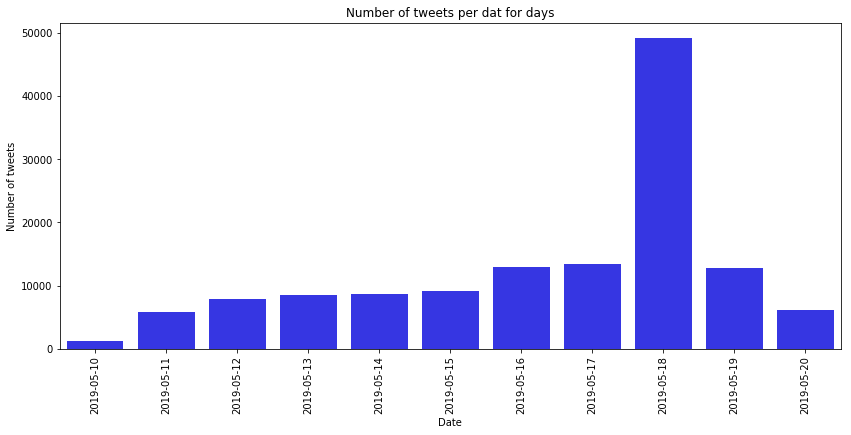

In [18]:
# Exploring the 'created_at' column

twitter_data['created_at'] = pd.to_datetime(twitter_data['created_at'])
cnt_srs = twitter_data['created_at'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14, 6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha = 0.9, color = 'blue')
plt.xticks(rotation = 'vertical')
plt.xlabel('Date', fontsize= 10)
plt.ylabel('Number of tweets', fontsize = 10)
plt.title('Number of tweets per dat for days')
plt.show()

In [19]:
# We can conclude that most people tweetedd on 2019-05-18. Around 48000 tweets.

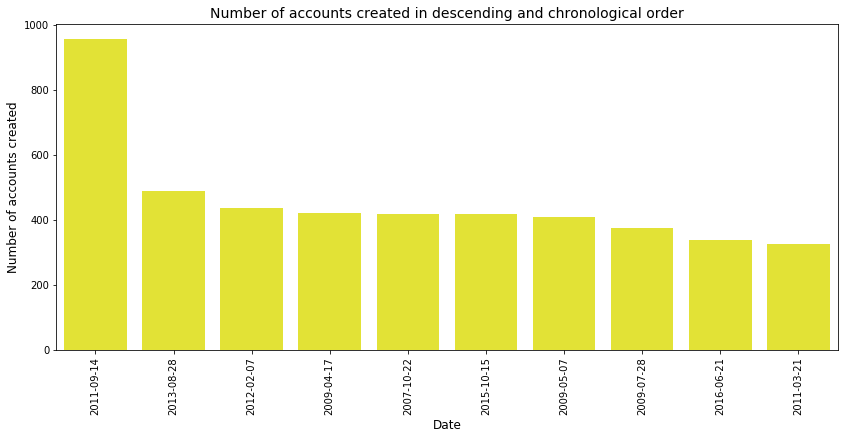

In [20]:
# Dates on which most accounts were created

count_ = twitter_data['user_created_at'].dt.date.value_counts()
count_ = count_[:10,]
plt.figure(figsize = (14, 6))
sns.barplot(count_.index, count_.values, alpha = 0.9, color='yellow')
plt.title('Number of accounts created in descending and chronological order', fontsize = 14)
plt.xticks(rotation = 'vertical')
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Number of accounts created', fontsize = 12)
plt.show()

In [21]:
# Most accounts were created on the date '2011-09-14'. Around 950 accounts.

In [22]:
# extracting the day names from the data

twitter_data['tweeted_day_of_week'] = twitter_data['created_at'].dt.weekday_name
twitter_data['created_day_of_week'] = twitter_data['user_created_at'].dt.weekday_name

In [23]:
cnt_ = twitter_data['tweeted_day_of_week'].value_counts()
cnt_ = cnt_.sort_index()

fig = {
    "data" : [
        {
            "values" : cnt_.values,
            "labels" : cnt_.index,
            "domain" : {"x": [0, 0.5]},
            "hoverinfo" : "label + percent + name",
            "hole" : .3,
            "type" : "pie"
        },],
    "layout" :{
        "title" : "Percentage of tweets per days of the week",
        "annotations" : [
            {
                "font" : {"size" : 10},
                "showarrow" : False,
                "text" : "Percentage of tweets per days of the week",
                "x" : 0.50,
                "y" : 1
            },
        ]
    }
}

iplot(fig)
cnt_

Friday       14622
Monday       14651
Saturday     54879
Sunday       20598
Thursday     12891
Tuesday       8600
Wednesday     9139
Name: tweeted_day_of_week, dtype: int64

In [24]:
# Treemap of number of tweets by days of the week

x = 0.
y = 0.
width = 50.
height = 50.

type_list = list(twitter_data['tweeted_day_of_week'].unique())
values = [len(twitter_data[twitter_data['tweeted_day_of_week'] == i]) for i in type_list]

normed = squarify.normalize_sizes(values, width, height)
rects = squarify.squarify(normed, x, y, width, height)
color_brewer = ['#2D3142','#4F5D75','#BFC0C0','#F2D7EE','#EF8354','#839788','#EEE0CB']

shapes = []
annotations = []
counter = 0

for r in rects:
    shapes.append(
            dict(
                type = 'rect',
                x0 = r['x'],
                y0 = r['y'],
                x1 = r['x'] + r['dx'],
                y1 = r['y'] + r['dy'],
                line = dict(width = 2),
                fillcolor = color_brewer[counter]
            )
        )
    
    annotations.append(
            dict(
                x = r['x']+(r['dx']/2),
                y = r['y']+(r['dy']/2),
                text = "{}-{}".format(type_list[counter], values[counter]),
                showarrow = False
            )
        )
    counter = counter + 1
    if counter >= len(color_brewer):
        counter = 0
        
# for hover text
trace0 = go.Scatter(
    x = [ r['x']+(r['dx']/2) for r in rects ], 
    y = [ r['y']+(r['dy']/2) for r in rects ],
    text = [ str(v) for v in values ], 
    mode = 'text',
)
        
layout = dict(
    height=700, 
    width=700,
    xaxis=dict(showgrid=False,zeroline=False),
    yaxis=dict(showgrid=False,zeroline=False),
    shapes=shapes,
    annotations=annotations,
    hovermode='closest',
    font=dict(color="#FFFFFF")
)

# With hovertext
figure = dict(data=[trace0], layout=layout)
iplot(figure, filename='squarify-treemap')

In [25]:
# Most of the tweets were tweeted on Saturday and Sunday

In [31]:
# extracting the hours from created_at and users_created at column

twitter_data['created_at_hour'] = twitter_data['created_at'].dt.hour
twitter_data['user_crated_at_hour'] = twitter_data['user_created_at'].dt.hour

In [35]:
# plotting number of tweets per hour

cnt_ = twitter_data['created_at_hour'].value_counts()
cnt_ = cnt_.sort_index()
trace1 = go.Scatter(
                x = cnt_.index,
                y = cnt_.values,
                mode = "lines",
                name = "citations",
                marker = dict(color = "rgba(16, 112, 2, 0.8)")
            )

data = [trace1]
layout =  dict(title = "number of tweets per hour",
               xaxis = dict(title = "Tweets per hour", ticklen = 5, zeroline = False)
              )
fig = dict(data = data, layout = layout)
iplot(fig)

In [36]:
# plotting number of accounts created per hour

cnt_ = twitter_data['user_crated_at_hour'].value_counts()
cnt_ = cnt_.sort_index()

trace1 = go.Scatter(
                x = cnt_.index,
                y = cnt_.values,
                mode = 'lines',
                name = 'citations',
                marker = dict(color = 'rgba(210, 113, 25, 0.8)')
            )

data = [trace1]
layout = dict(title = "Number of accounts created per hour",
             xaxis = dict(title = "Accounts per hour",
             ticklen = 5,
             zeroline = False))
fig = dict(data = data, layout = layout)
iplot(fig)

In [42]:
# Checking most retweeted and most liked tweet

print(f' Most retweeted tweet {twitter_data.retweet_count.max()}')
print(f' Most liked/favorite tweet {twitter_data.favorite_count.max()}')

twitter_data.loc[twitter_data['retweet_count']==6622.0,'full_text'].values
twitter_data.loc[twitter_data['favorite_count']==15559.0,['full_text', 'user_name', 'user_description']].values


 Most retweeted tweet 6622.0
 Most liked/favorite tweet 15559.0


array([["Shocking defeat for Left in Australia, stunned pollsters and mainstream media who had predicted this election as 'unlosable for Labor'. Conservative @ScottMorrisonMP focused on 'Australian First', Jobs and Imigration, while Labor focused on #ClimateChange https://t.co/hFt7vgwuEd",
        'Sara A. Carter',
        '@FoxNews Contributor, award winning National Security/War Correspondent. @IWF Fellow. Taking back the story. Follow me on Instagram ScarterDC']],
      dtype=object)

In [43]:
# the most retweeted and most liked tweet is the same with username = 'Sara A. Carter'

In [44]:
# Most number of occurances of a person

twitter_data.user_name.value_counts()[:5,]

💧 Sur Plus               937
PM of Australia News     464
🌹MsRose🌹                 415
🍌Leftie Troublemaker🍍    386
Jackie Moss ☔️           300
Name: user_name, dtype: int64

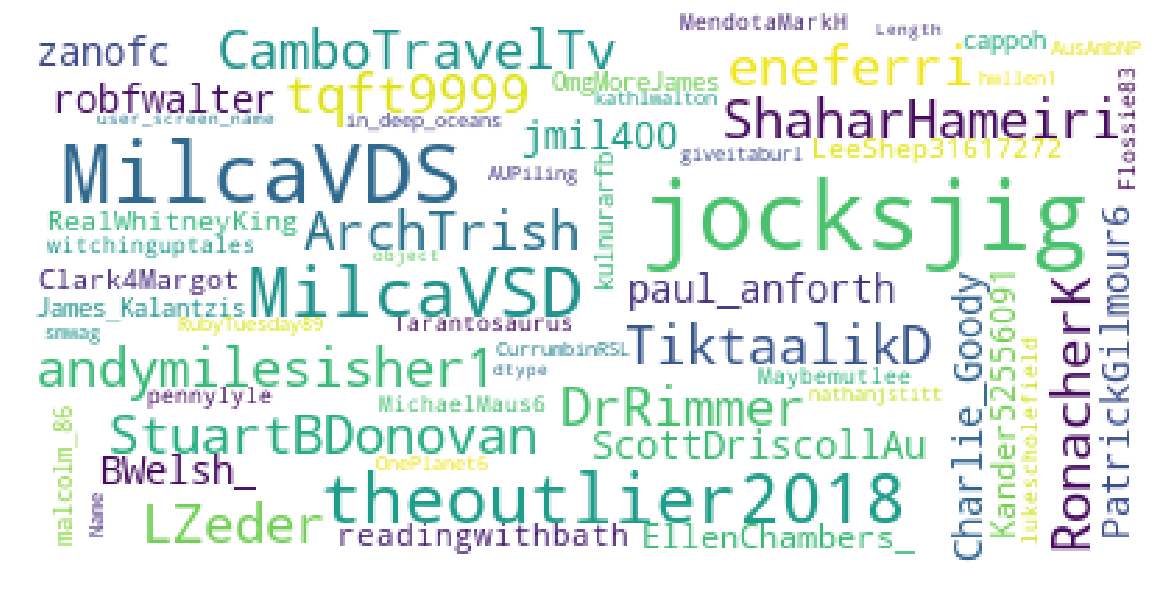

In [47]:
# Word cloud of the users

wordcloud__ = WordCloud(
                    background_color= 'white',
                    stopwords = set(STOPWORDS),
                    max_words = 250,
                    max_font_size = 34,
                    random_state = 2566
                    ).generate(str(twitter_data['user_screen_name'].dropna()))
def cloud_plot(wordcloud):
    fig = plt.figure(figsize= (20, 15))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
cloud_plot(wordcloud__)

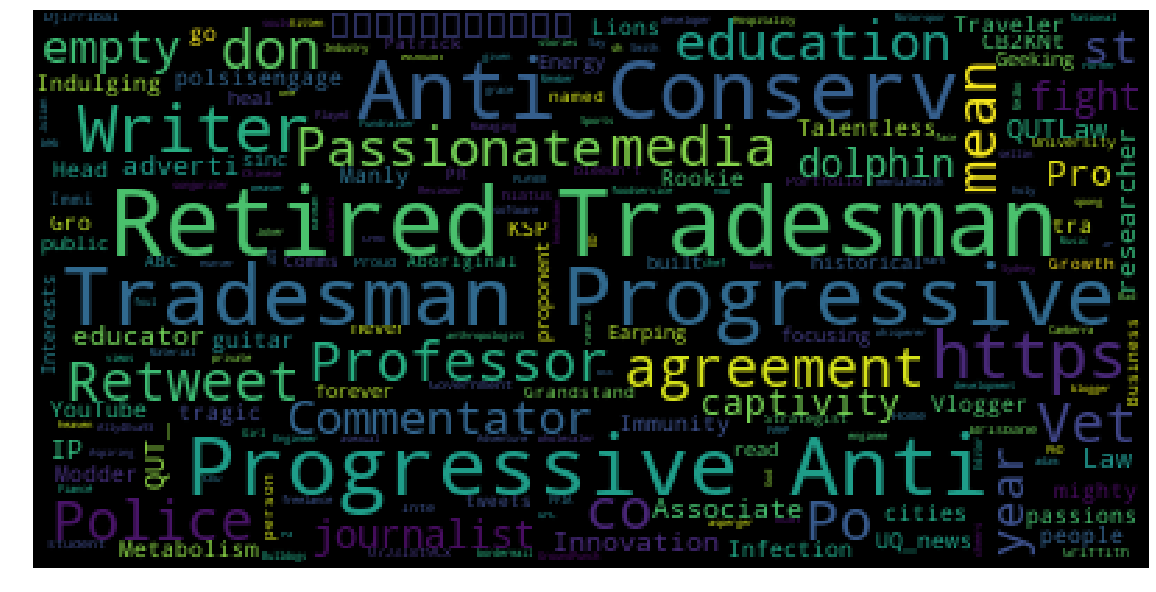

In [48]:
# Wordcloud of user description

wordcloud_ = WordCloud(
                    background_color= 'black',
                    stopwords = set(STOPWORDS),
                    max_words = 250,
                    max_font_size = 34,
                    random_state = 2566
                    ).generate(str(twitter_data['user_description'].dropna()))
def cloud_plot(wordcloud):
    fig = plt.figure(figsize= (20, 15))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
cloud_plot(wordcloud_)


In [50]:
twitter_data['sentiment'] = twitter_data['full_text'].map(lambda text: TextBlob(text).sentiment.polarity)

In [53]:
# Checking different tweets with different sentiments

print(" five random tweets with highest negative sentiment polarity : \n")
cL = twitter_data.loc[twitter_data.sentiment == -1, ['full_text']].sample(5).values
for c in cL:
    print(c[0])
    print()

 five random tweets with highest negative sentiment polarity : 

Voted today and very disappointed there was not a #DemocracySausage in sight!

#AusPol https://t.co/pVCLKJnh5u

The pic of shame &amp; it happens in #polisario gulags #SouthAlgeria 🇪🇭. #westernsahara #community disgusted by the sponsored blindness of politicians, journalists, NGOs....#UNHCR #WFP #SaharaOccidental #svpol #dkpol #nrk #vg #suomi #auspol  #nzpol #UKpol #USpolitics #cndpoli #nieuws https://t.co/aOz6Ps9QD1

Bill did not say this. Pathetic from the Oz. #auspol. https://t.co/g3EvimYn9d

During the Fraser/Hawke/Keating years there was a consensus on taking in asylum seekers and refugees.

Now the racist Stop the Boats bullshit infects both Government and Opposition. It's disgusting.

#AusPol #ValeBob

Paul why don't you talk about the disgusting scare campaigns based on lies being carried out.  This is just one example. #auspol https://t.co/8IrXfP9goi



In [55]:
print("5 random tweets with neutral sentiment polarity: \n")
cL = twitter_data.loc[twitter_data.sentiment==0, ['full_text']].sample(5).values
for c in cL:
    print(c[0])
    print()

5 random tweets with neutral sentiment polarity: 

Morrison visits Sydney Markets as polling day draws close: https://t.co/7YYipFLVCa #auspol #australiapm

The lighter side of #ausvotes - @choiceaustralia's democracy sausage test! https://t.co/UKm8QPdynN https://t.co/thwjuXKOB5

The funnest part of watching the #ausvotes coverage is seeing what the electorates are called

#auspol https://t.co/PC1Ck8F1Hl

The Far-Left Lost an "Unlosable" National Election in Australia Last Night and It's Glorious https://t.co/MCHaQNXOun



In [56]:
# Histogram plot of sentiment

trace1 = go.Histogram(
            x = twitter_data['sentiment'],
            opacity= 0.6,
            name = " sentiment",
            marker = dict(color = 'rgba(122, 75, 196, 0.6)'))

data = [trace1]
layout = go.Layout(barmode = 'overlay',
                  title = 'Histogram plt of sentiments of tweets',
                  xaxis = dict(title = 'sentiment'),
                  yaxis = dict(title = "Count"),)

fig = go.Figure(data = data, layout = layout)
iplot(fig)

                

In [57]:
# We see that around 49k tweets have zero polarity

In [58]:
# Mapping sentiments to polarities

cut = pd.cut(
    twitter_data['sentiment'],
    [-np.inf, -.01, .01, np.inf],
    labels=['negative', 'neutral', 'positive']
)
twitter_data['polarity'] = cut.values
twitter_data[['polarity','sentiment']][:20]

polarity  sentiment
0   negative  -0.200000
1   negative  -0.600000
2    neutral   0.000000
3   negative  -0.200000
4   negative  -0.035714
5   positive   0.500000
6   positive   0.136364
7   positive   0.050000
8   positive   0.300000
9   positive   0.200000
10   neutral   0.000000
11  negative  -0.250000
12  positive   0.366667
13   neutral  -0.002222
14  positive   0.500000
15   neutral   0.000000
16   neutral   0.000000
17  negative  -0.266667
18  positive   0.125000
19   neutral   0.000000

In [59]:
twitter_data.head()

created_at                   id  \
0 2019-05-20 09:13:44  1130401208756187136   
1 2019-05-20 09:12:57  1130401009782673408   
2 2019-05-20 09:02:04  1130398270813949952   
3 2019-05-20 07:25:41  1130374015103537152   
4 2019-05-20 07:12:01  1130370578584461313   

                                           full_text  retweet_count  \
0  After the climate election: shellshocked green...            0.0   
1  It is disappointing that @tanya_plibersek has ...            0.0   
2  'Vote for the climate': NSW demands environmen...            0.0   
3  This is urgent! “False election claims spark p...            0.0   
4  This is a great piece, not least because it pl...            0.0   

   favorite_count       user_id       user_name user_screen_name  \
0             0.0  9.248486e+07    PIPELINEPETE         jocksjig   
1             0.0  5.100258e+07  Matthew Rimmer         DrRimmer   
2             0.0  9.248486e+07    PIPELINEPETE         jocksjig   
3             0.0  3.327641e+08         E Ferri         eneferri   
4             2.0  2.180023e+09  Shahar Hameiri    ShaharHameiri   

                                    user_description         user_location  \
0  Retired Tradesman and Progressive Anti Conserv...  Brisbane, Queensland   
1  Professor of IP & Innovation Law @QUTLaw @QUT_...  Brisbane, Queensland   
2  Retired Tradesman and Progressive Anti Conserv...  Brisbane, Queensland   
3  Writer, researcher, educator in media, adverti...  Brisbane, Queensland   
4  Associate Professor @polsisengage @UQ_news. Po...  Brisbane, Queensland   

      user_created_at        lat        long tweeted_day_of_week  \
0 2009-11-25 09:19:45 -27.469771  153.025124              Monday   
1 2009-06-26 10:17:54 -27.469771  153.025124              Monday   
2 2009-11-25 09:19:45 -27.469771  153.025124              Monday   
3 2011-07-10 11:20:43 -27.469771  153.025124              Monday   
4 2013-11-07 12:39:24 -27.469771  153.025124              Monday   

  created_day_of_week  crated_at_hour  user_crated_at_hour  created_at_hour  \
0           Wednesday               9                    9                9   
1              Friday               9                   10                9   
2           Wednesday               9                    9                9   
3              Sunday               7                   11                7   
4            Thursday               7                   12                7   

   sentiment  polarity  
0  -0.200000  negative  
1  -0.600000  negative  
2   0.000000   neutral  
3  -0.200000  negative  
4  -0.035714  negative

In [60]:
twitter_data['polarity'].value_counts()


positive    58448
neutral     48831
negative    28101
Name: polarity, dtype: int64